## Standard package imports

In [528]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score

from xgboost import XGBClassifier

# Import the preprocessing function from the Python script
from lifestyle_factors_and_diabetes_problem_definition_and_data import preprocess_and_split_data

### Loading Dataset

In [250]:
# Load the merged_data.pkl file
import pickle
with open('merged_data.pkl', 'rb') as f:
    merged_data = pickle.load(f)

# Display the first few rows to confirm the data is loaded correctly
print("Data loaded successfully!")
merged_data.head(2)

Data loaded successfully!


Sex  Sleep  Physical_Activity  Alcohol_Consumption  Smoker  \
0    0      1                  0                    0       0   
1    0      1                  0                    0       0   

   Unified_Diabetes  Age_Category  Sleep_Physical_Activity  \
0                 0             1                        0   
1                 0             1                        0   

   Alcohol_Consumption_Smoker  Sleep_Alcohol_Consumption  Fruits_Veggies  
0                           0                          0               2  
1                           0                          0               2

In [251]:
# Sample 10% of the data
merged_data_sampled = merged_data.sample(frac=0.1, random_state=42)

# Call the preprocess_and_split_data function on the sampled data
X_train, X_test, y_train, y_test = preprocess_and_split_data(merged_data_sampled)

# Confirm the splits
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (14808, 10)
Test features shape: (3703, 10)
Training target shape: (14808,)
Test target shape: (3703,)


In [252]:
# Define the VIF calculation function
def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the dataset.

    Parameters:
    - X: The DataFrame of features.

    Returns:
    - vif_data: A DataFrame containing features and their respective VIF values.
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for training features
vif_df = calculate_vif(X_train)

# Display VIF results
vif_df

Feature        VIF
0                         Sex   5.716801
1                       Sleep  11.038174
2           Physical_Activity  10.268422
3         Alcohol_Consumption   6.914345
4                      Smoker   4.554427
5                Age_Category   3.458788
6     Sleep_Physical_Activity   4.206247
7  Alcohol_Consumption_Smoker   4.628993
8   Sleep_Alcohol_Consumption   6.777078
9              Fruits_Veggies  11.500162

#### Key Observations on VIF:
#### High Multicollinearity Indicators:

**Sleep has a VIF of 10.82.**
**Physical_Activity has a VIF of 10.16.**
**Fruits_Veggies has a VIF of 11.43.**
These features exceed the commonly accepted threshold of 10 for multicollinearity concerns.
#### Moderate VIF Values:
Features like Sex, Alcohol_Consumption, and others have VIFs below 10, suggesting lower multicollinearity.

### Handling High-VIF Features

### I tried using Principal Component Analysis (PCA) and also combine those highly related features but did not reduce multicollinearity. Therefore, I'm going to drop those features to reduce multicollinearity. I really want to keep them, but previously my models overfit, and I don't want that happen again. 

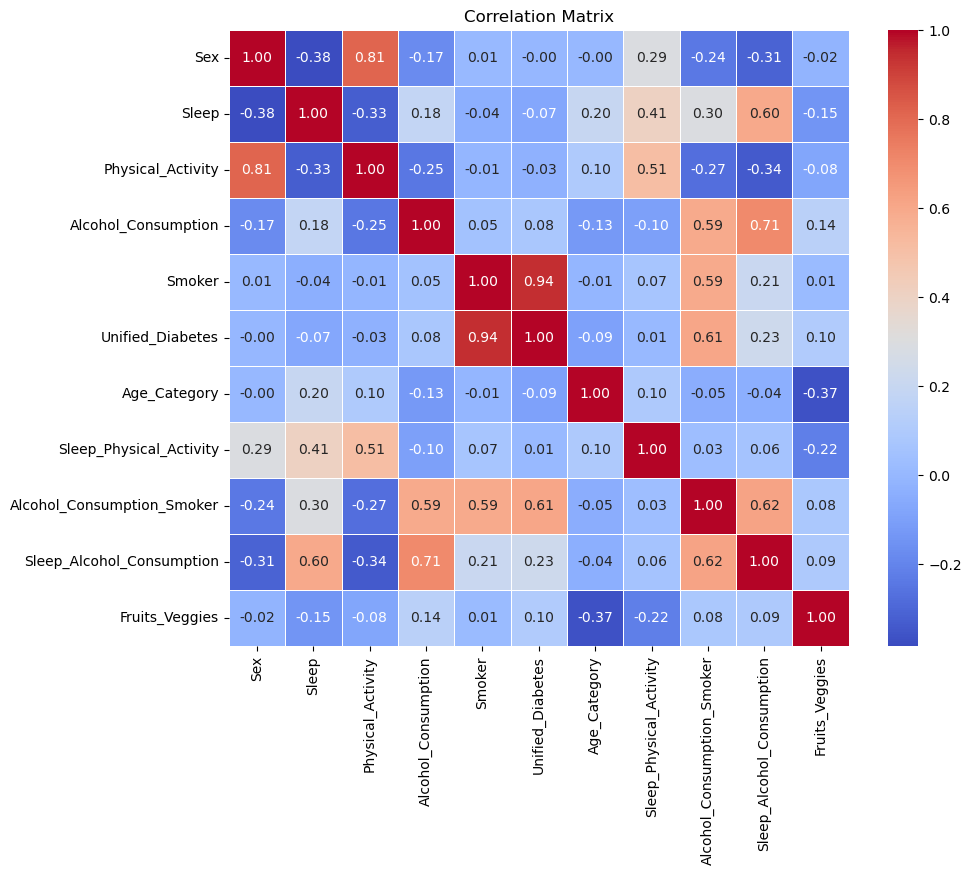

In [256]:
# Compute the correlation matrix
correlation_matrix = merged_data.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [267]:
# Drop features with high VIF (multicollinearity)
features_to_drop = ['Sleep', 'Physical_Activity', 'Fruits_Veggies']
merged_data = merged_data.drop(columns=features_to_drop)

# Now split the data again for train and test
# Sample 10% of the data
merged_data_sampled = merged_data.sample(frac=0.1, random_state=42)
X_train, X_test, y_train, y_test = preprocess_and_split_data(merged_data_sampled)

# Confirm the splits
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (14808, 7)
Test features shape: (3703, 7)
Training target shape: (14808,)
Test target shape: (3703,)


In [269]:
# Calculate VIF for training features
vif_df = calculate_vif(X_train)

# Display VIF results
vif_df

Feature       VIF
0                         Sex  2.199678
1         Alcohol_Consumption  4.423662
2                      Smoker  3.228110
3                Age_Category  1.944891
4     Sleep_Physical_Activity  1.479590
5  Alcohol_Consumption_Smoker  4.132482
6   Sleep_Alcohol_Consumption  3.702122

In [68]:
# Preprocessing function
def create_preprocessor(X, degree=None):
    # Select numerical features
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    # Create polynomial transformer if a degree is provided
    poly_transformer = PolynomialFeatures(degree=degree) if degree else PolynomialFeatures()
    
    # Create a pipeline for numerical features that includes scaling and polynomial transformation
    numerical_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', poly_transformer)
    ])
    
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features)
        ]
    )
    
    return preprocessor

In [ ]:
dt_model knn = Pipeline([


## Model-1 Decision Tree

In [459]:
# Define the Decision Tree model
pipeline_dt = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing (reuse the function for preprocessing)
    ('dt', DecisionTreeClassifier(random_state=42))   # Decision Tree Classifier
])

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': [None, 'sqrt', 'log2']
}

# Perform GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(
    dt_model,
    param_grid_dt,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Print the best parameters and best cross-validation score
print(f"Best Parameters: {grid_search_dt.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search_dt.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'dt__max_depth': None, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best Cross-validation Accuracy: 0.9905


### Model Evaluation

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2040
           1       1.00      0.98      0.99      1663

    accuracy                           0.99      3703
   macro avg       0.99      0.99      0.99      3703
weighted avg       0.99      0.99      0.99      3703



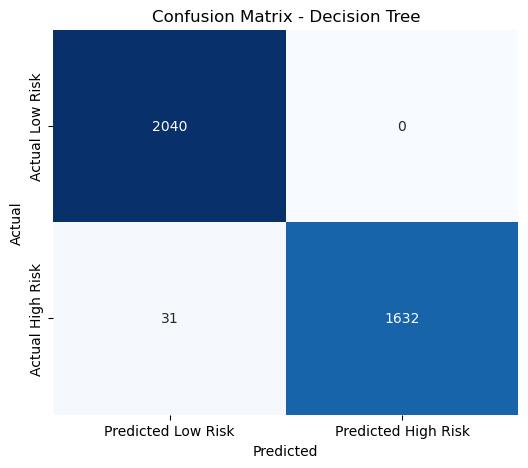

In [436]:
# Get the best estimator (the one with the best parameters from GridSearchCV)
best_dt = grid_search_dt.best_estimator_

# Make predictions on the test set
y_pred_dt = best_dt.predict(X_test)
y_pred_prob_dt = best_dt.predict_proba(X_test)[:, 1]  # For AUC calculation

# Compute confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Low Risk', 'Predicted High Risk'], 
            yticklabels=['Actual Low Risk', 'Actual High Risk'])
plt.title("Confusion Matrix - Decision Tree")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model Visualization

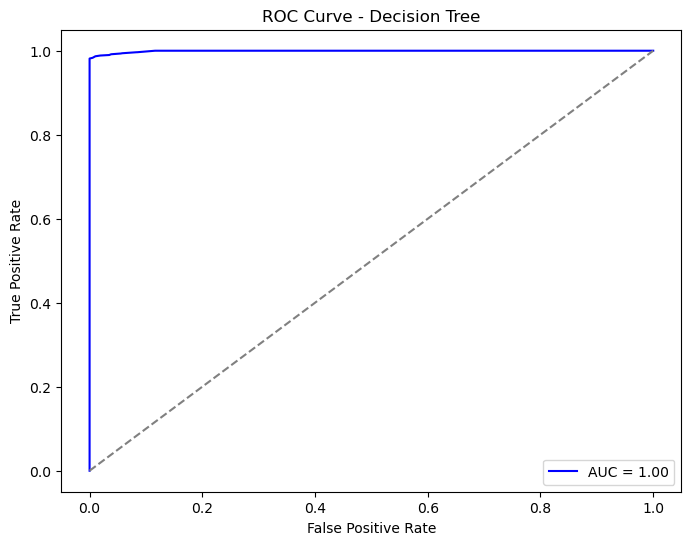

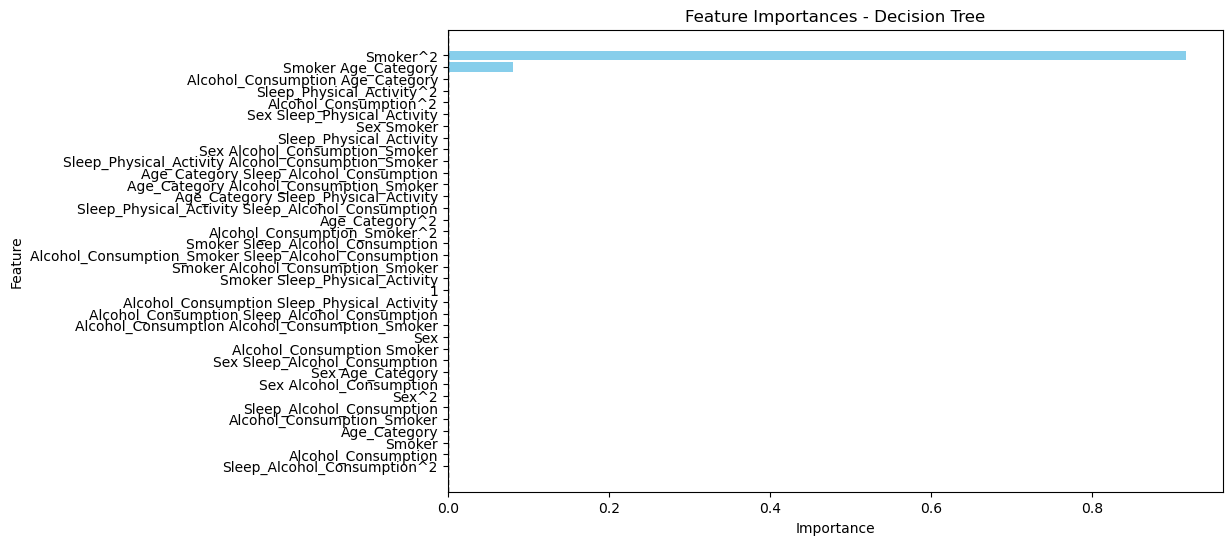

In [444]:
# ROC Curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='b', label=f'AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Feature Importances from the Decision Tree model
feature_importances_dt = best_dt.named_steps['dt'].feature_importances_

# Get the features after preprocessing (taking the transformed feature names)
# If you're using transformers like one-hot encoding, you should extract column names post-transformation
preprocessor = best_dt.named_steps['preprocessor']

# Check if the preprocessor is a column transformer (like one-hot encoding or scaling)
if hasattr(preprocessor, 'transformers_'):
    # For a column transformer with categorical transformations (like one-hot encoding), 
    # we extract the columns for one-hot encoded features.
    feature_names_dt = preprocessor.transformers_[0][1].get_feature_names_out(input_features=X_test.columns)
else:
    # If no transformation, just use the original feature names
    feature_names_dt = X_test.columns

# Ensure the length of feature_names_dt matches the length of feature_importances_dt
assert len(feature_names_dt) == len(feature_importances_dt), "Feature names and importances must have the same length"

# Create a DataFrame for feature importances
importances_df_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Importance': feature_importances_dt
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df_dt['Feature'], importances_df_dt['Importance'], color='skyblue')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.title("Feature Importances - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



## Model-2 K-Nearest Neighbors (KNN) 

In [347]:
# Define the KNN pipeline
pipeline_knn = Pipeline([
    ('preprocessor', create_preprocessor(X_train, degree=None)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for KNN
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Set up GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='accuracy',  # Or your preferred metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Display best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-validation Score:", grid_search_knn.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Best Cross-validation Score: 0.9904781744036416


### Model Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2040
           1       1.00      0.98      0.99      1663

    accuracy                           0.99      3703
   macro avg       0.99      0.99      0.99      3703
weighted avg       0.99      0.99      0.99      3703



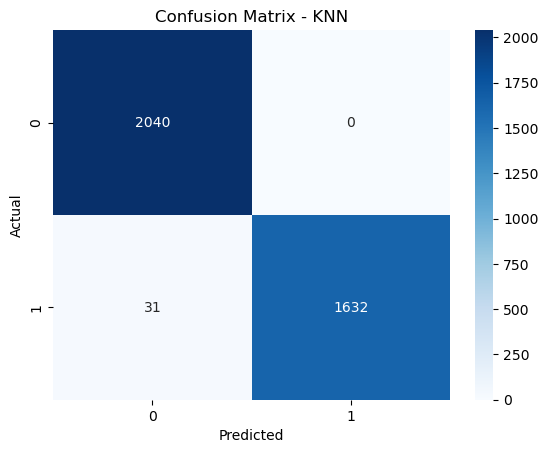

In [353]:
# Evaluate on the test set
y_test_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred_knn))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_knn)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model Visualization

ROC AUC: 1.00


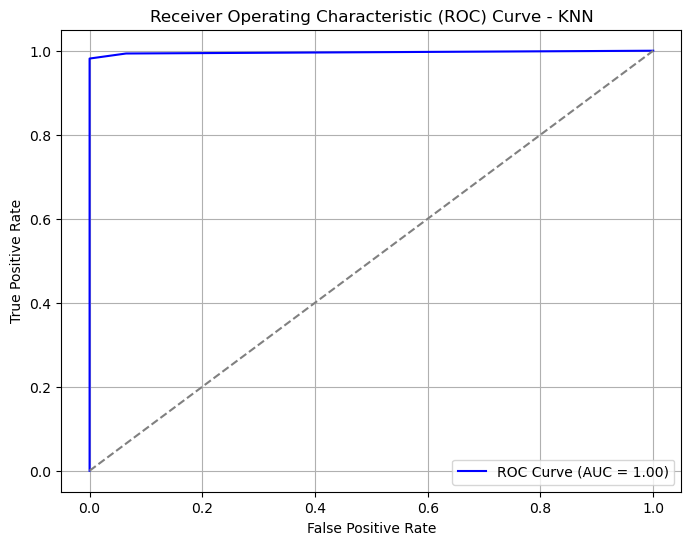

In [355]:
# Get predicted probabilities for the positive class
y_test_proba_knn = grid_search_knn.best_estimator_.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_knn)

# Compute the AUC
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.title("Receiver Operating Characteristic (ROC) Curve - KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model-3 Logistic Regression

In [494]:
# Define the pipeline
pipeline_log_reg = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing
    ('log_reg', LogisticRegression(random_state=42, max_iter=1000))  # Logistic Regression
])

# Define the parameter grid for Logistic Regression
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Hyperparameter tuning for regularization strength
}

# Set up GridSearchCV
grid_search_log_reg = GridSearchCV(
    estimator=pipeline_log_reg,
    param_grid=param_grid,
    scoring='f1',  # You can change this to 'accuracy', 'precision', or 'recall' if needed
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    verbose=1  # Display progress
)

# Fit the model with GridSearchCV
grid_search_log_reg.fit(X_train, y_train)

# Get the best pipeline from the grid search
best_log_reg = grid_search_log_reg.best_estimator_

# Print the best parameters and F1 score from GridSearchCV
print("Best parameters:", grid_search_log_reg.best_params_)
print("Best F1 Score from GridSearchCV:", grid_search_log_reg.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'log_reg__C': 0.1}
Best F1 Score from GridSearchCV: 0.9894082171819033


### Model Evaluation

In [502]:
# Calculate predictions and predicted probabilities on the test set
y_pred_log_reg = best_log_reg.predict(X_test)
y_pred_proba_log_reg = best_log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Evaluate model performance
train_score_log_reg = best_log_reg.score(X_train, y_train)
test_score_log_reg = best_log_reg.score(X_test, y_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Print evaluation metrics
print(f"Logistic Regression Train Score: {train_score_log_reg:.4f}")
print(f"Logistic Regression Test Score: {test_score_log_reg:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print(f"Logistic Regression Precision: {precision_log_reg:.4f}")
print(f"Logistic Regression Recall: {recall_log_reg:.4f}")
print(f"Logistic Regression F1 Score: {f1_log_reg:.4f}")


Logistic Regression Train Score: 0.9905
Logistic Regression Test Score: 0.9916
Logistic Regression Accuracy: 0.9916
Logistic Regression Precision: 1.0000
Logistic Regression Recall: 0.9814
Logistic Regression F1 Score: 0.9906


### Model Visualization

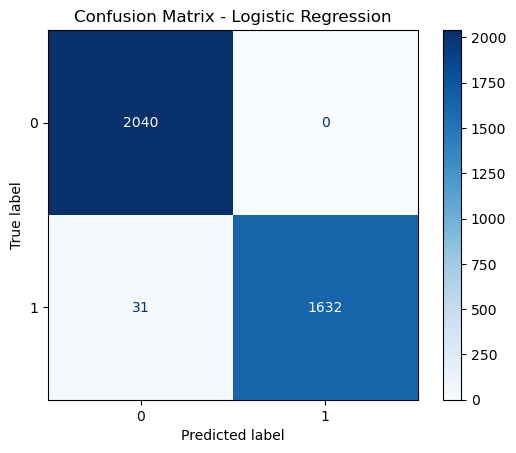

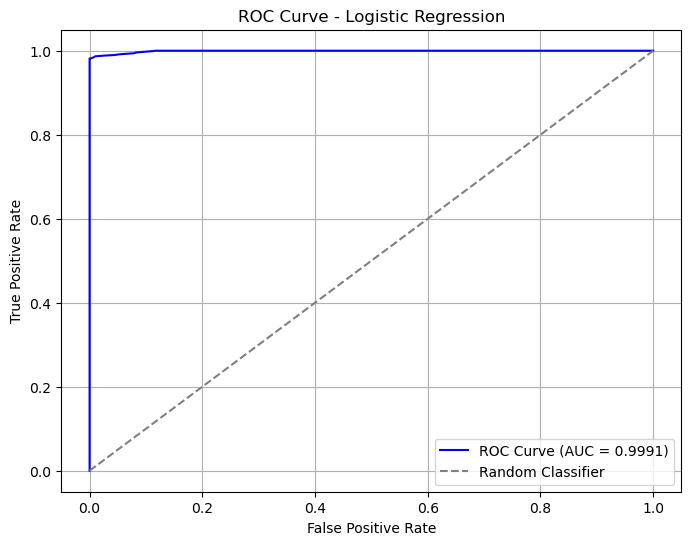

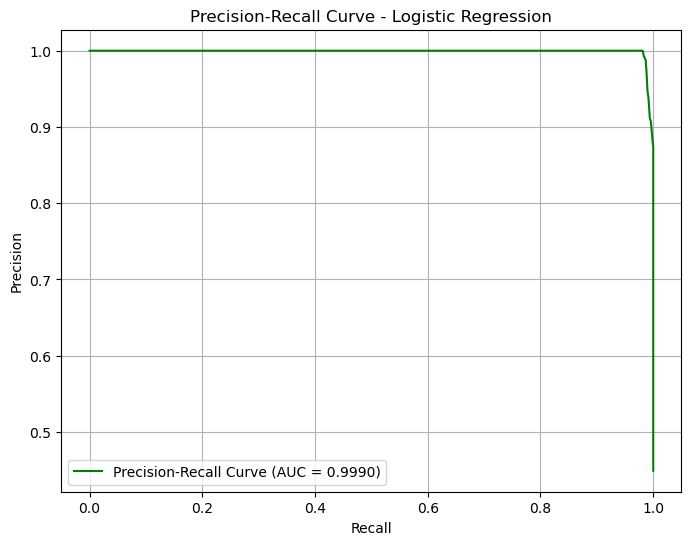

In [504]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log_reg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_log_reg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_log_reg)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.title("Precision-Recall Curve - Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

## Model-4 Support Vector Classifier (SVC)

In [370]:
# Define the pipeline
svc_pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing with create_preprocessor
    ('svc', SVC(probability=True))  # Enable probability estimates for SVC
])

# Define the parameter grid
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto'],
    'svc__degree': [2, 3]  # Only relevant for 'poly' kernel
}

# Perform GridSearchCV
grid_search_svc = GridSearchCV(
    svc_pipeline, 
    param_grid_svc, 
    scoring='accuracy', 
    cv=5, 
    verbose=2,
    n_jobs=-1
)
grid_search_svc.fit(X_train, y_train)

# Print the best parameters and cross-validation accuracy
print(f"Best Parameters: {grid_search_svc.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search_svc.best_score_:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best Cross-validation Accuracy: 0.9905


### Model Evaluation

In [373]:
# Get the best model from grid search
best_svc = grid_search_svc.best_estimator_

# Make predictions
y_test_pred_svc = best_svc.predict(X_test)

# Evaluate accuracy
test_accuracy_svc = accuracy_score(y_test, y_test_pred_svc)
print(f"Test Accuracy: {test_accuracy_svc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_svc))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_svc)
print("\nConfusion Matrix:")
conf_matrix

Test Accuracy: 0.9916

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2040
           1       1.00      0.98      0.99      1663

    accuracy                           0.99      3703
   macro avg       0.99      0.99      0.99      3703
weighted avg       0.99      0.99      0.99      3703


Confusion Matrix:


array([[2040,    0],
       [  31, 1632]])

### Model Visualization

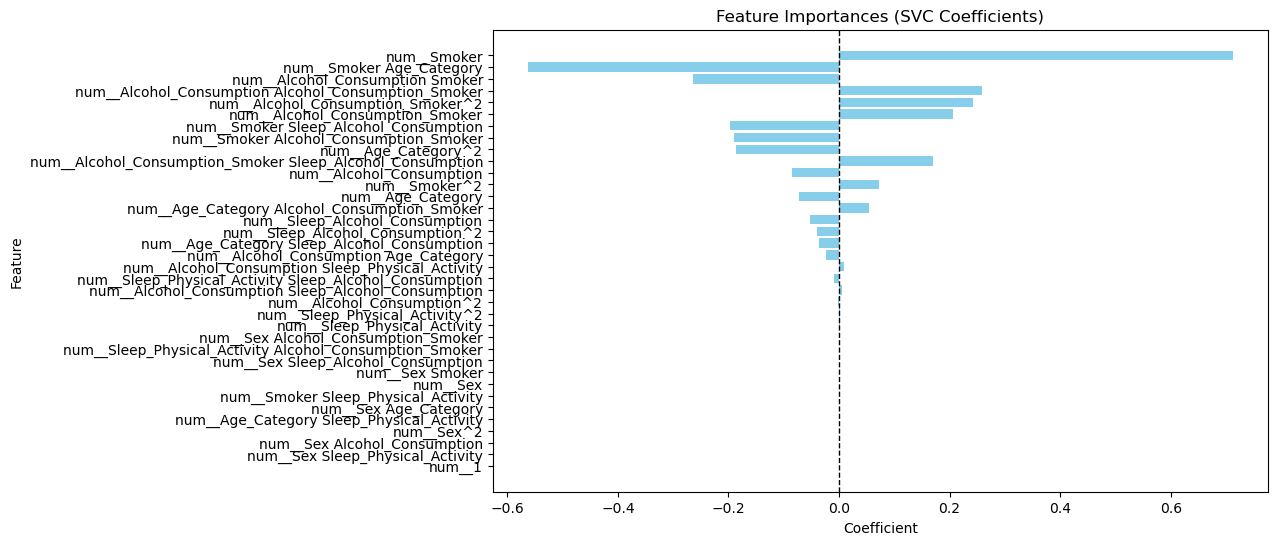

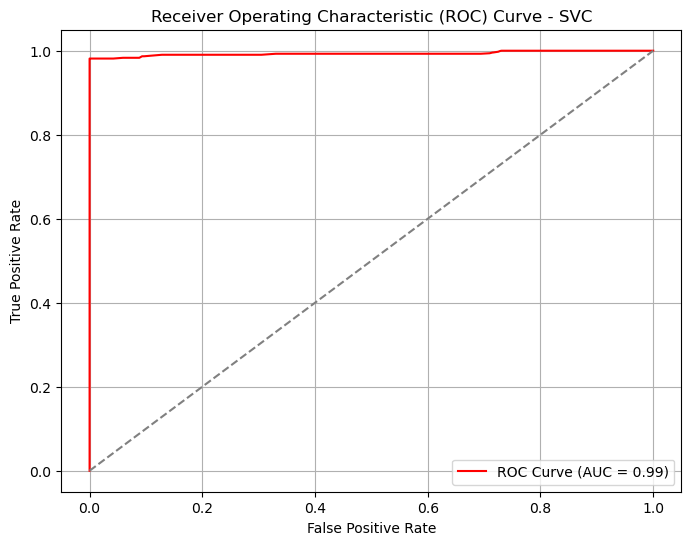

In [375]:
if 'linear' in grid_search_svc.best_params_['svc__kernel']:
    # Extract coefficients for linear kernel
    coefficients = best_svc.named_steps['svc'].coef_[0]
    feature_names = best_svc.named_steps['preprocessor'].get_feature_names_out()

    # Create a DataFrame for coefficients
    coeff_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False, key=abs)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='skyblue')
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.title("Feature Importances (SVC Coefficients)")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")

# Get predicted probabilities or decision scores
y_test_scores_svc = best_svc.decision_function(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores_svc)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve - SVC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model-5 Random Forest 

In [506]:
# Create the preprocessor using the function
preprocessor = create_preprocessor(X_train)

# Create the pipeline with the preprocessor and RandomForestClassifier
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__bootstrap': [True, False]
}

# Initialize the GridSearchCV with the pipeline and parameter grid
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best Cross-validation Accuracy: 0.9904781744036416


### Model Evaluation

In [306]:
# Evaluate the model on the test dataset
y_test_pred = grid_search_rf.predict(X_test)
y_test_proba = grid_search_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Test Accuracy: 0.9916
Test Precision: 1.0000
Test Recall: 0.9814
Test F1-Score: 0.9906
Test AUC: 0.9992


### Model Visualization

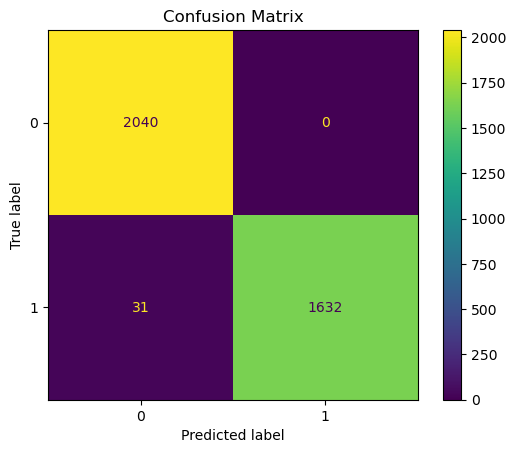

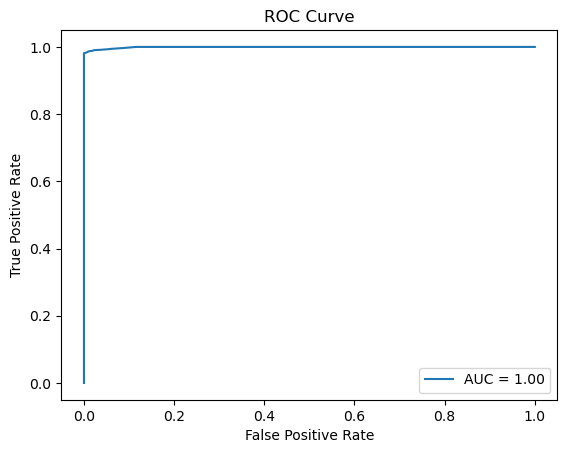

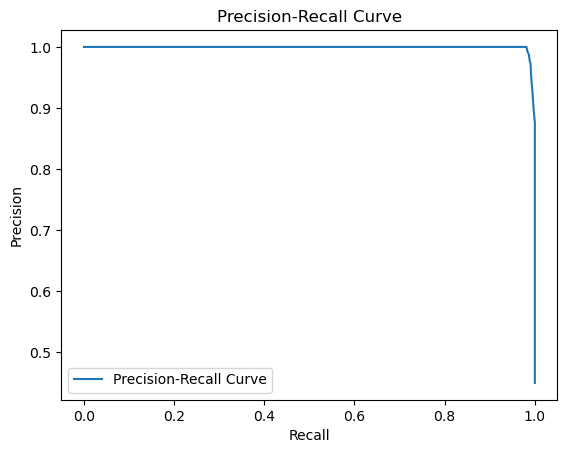

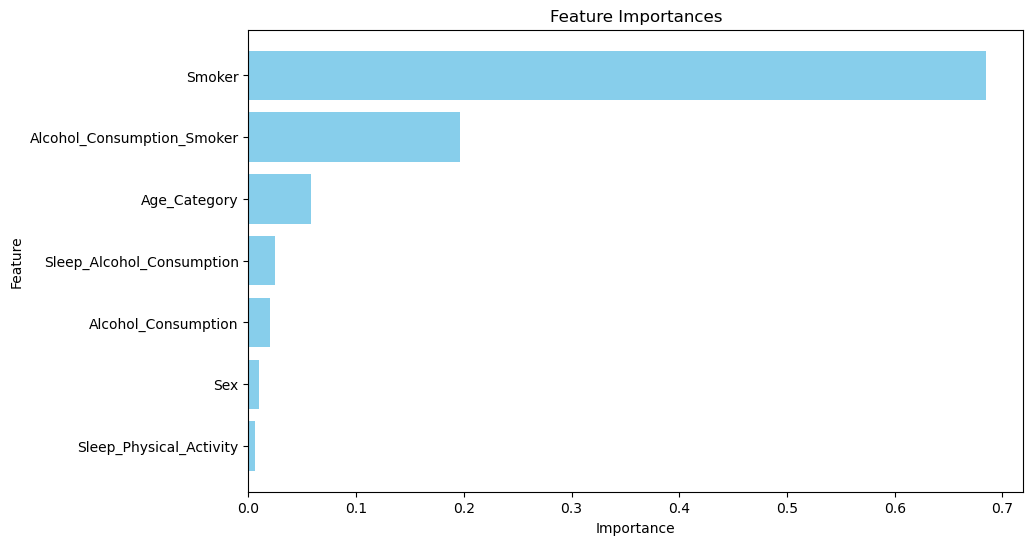

In [310]:
# Visualizing the Model’s Performance
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search_rf, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall curve
precisions, recalls, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Visualize feature importances
# Extract feature importances
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# Ensure the feature names are aligned with the test data columns
feature_names = X_test.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Model-6 Gradient Boosting (GB)

In [486]:
# Define the pipeline for Gradient Boosting
pipeline_gb = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing
    ('gb', GradientBoostingClassifier(random_state=42))  # Gradient Boosting Classifier
])

# Define the parameter grid
param_grid_gb = {
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_gb = GridSearchCV(
    gb_pipeline,
    param_grid_gb,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search_gb.fit(X_train, y_train)

# Print the best parameters and cross-validation accuracy
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search_gb.best_score_:.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 50}
Best Cross-validation Accuracy: 0.9905


### Model Evaluation

In [395]:
# Get the best model from grid search
best_gb = grid_search_gb.best_estimator_

# Make predictions
y_test_pred_gb = best_gb.predict(X_test)

# Evaluate accuracy
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
print(f"Test Accuracy: {test_accuracy_gb:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_gb))

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_test_pred_gb)
print("\nConfusion Matrix:")
print(conf_matrix_gb)


Test Accuracy: 0.9916

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2040
           1       1.00      0.98      0.99      1663

    accuracy                           0.99      3703
   macro avg       0.99      0.99      0.99      3703
weighted avg       0.99      0.99      0.99      3703


Confusion Matrix:
[[2040    0]
 [  31 1632]]


### Model Visualization

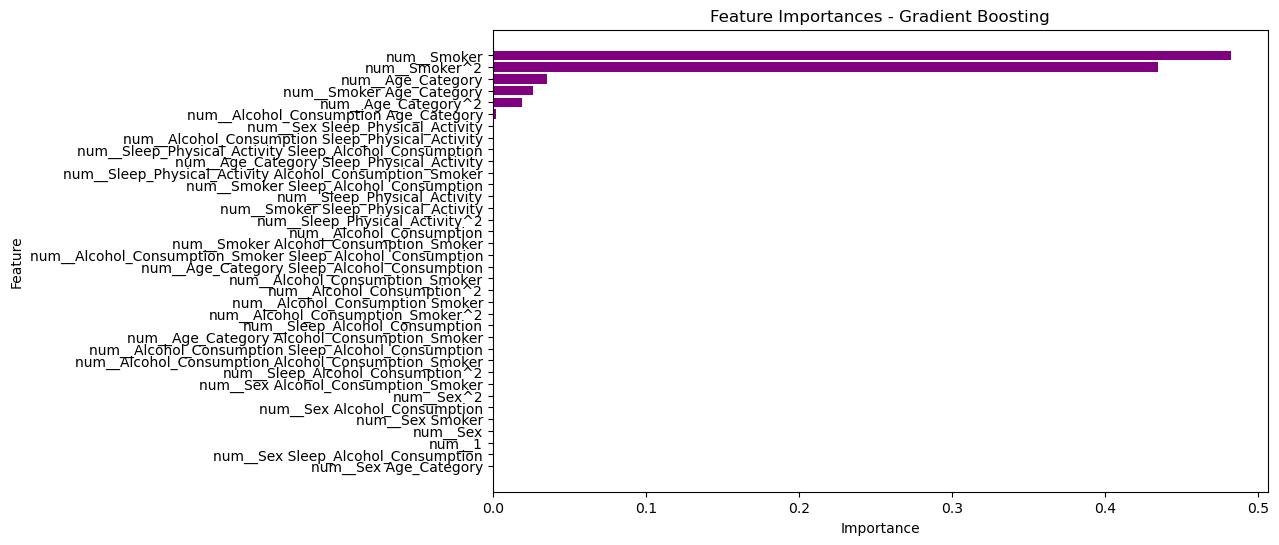

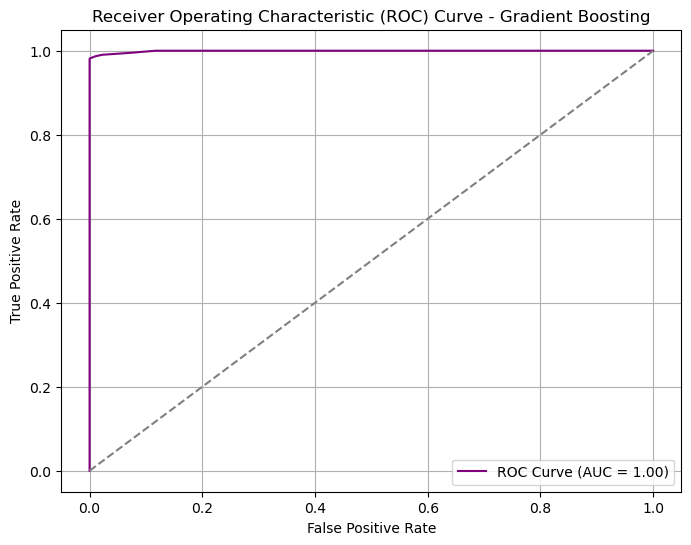

In [398]:
# Extract feature importances
feature_importances_gb = best_gb.named_steps['gb'].feature_importances_

# Ensure feature names align with the transformed dataset
feature_names = best_gb.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for feature importances
feature_importances_df_gb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_gb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_gb['Feature'], feature_importances_df_gb['Importance'], color='purple')
plt.gca().invert_yaxis()
plt.title("Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Get predicted probabilities
y_test_scores_gb = best_gb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_test_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='purple', label=f"ROC Curve (AUC = {roc_auc_gb:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve - Gradient Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model-7 AdaBoost

In [510]:
# Define the pipeline for AdaBoost
ab_pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing
    ('ab', AdaBoostClassifier(random_state=42, algorithm='SAMME'))  # Use SAMME to avoid warning
])

# Define the parameter grid
param_grid_ab = {
    'ab__n_estimators': [50, 100, 200],
    'ab__learning_rate': [0.01, 0.1, 1.0]
}

# Perform GridSearchCV
grid_search_ab = GridSearchCV(
    ab_pipeline,
    param_grid_ab,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search_ab.fit(X_train, y_train)

# Print the best parameters and cross-validation accuracy
print(f"Best Parameters: {grid_search_ab.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search_ab.best_score_:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'ab__learning_rate': 1.0, 'ab__n_estimators': 100}
Best Cross-validation Accuracy: 0.9905


### Model Evaluation

In [ ]:
# Get the best model from grid search
best_ab = grid_search_ab.best_estimator_

# Make predictions
y_test_pred_ab = best_ab.predict(X_test)

# Evaluate accuracy
test_accuracy_ab = accuracy_score(y_test, y_test_pred_ab)
print(f"Test Accuracy: {test_accuracy_ab:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_ab))

# Confusion matrix
conf_matrix_ab = confusion_matrix(y_test, y_test_pred_ab)
print("\nConfusion Matrix:")
print(conf_matrix_ab)


### Model Visualization

In [ ]:
# AdaBoost uses feature importance but it's a bit different, we need to get from the base estimator
feature_importances_ab = best_ab.named_steps['ab'].feature_importances_

# Ensure feature names align with the transformed dataset
feature_names = best_ab.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for feature importances
feature_importances_df_ab = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_ab
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_ab['Feature'], feature_importances_df_ab['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.title("Feature Importances - AdaBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Get predicted probabilities
y_test_scores_ab = best_ab.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test, y_test_scores_ab)
roc_auc_ab = auc(fpr_ab, tpr_ab)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='orange', label=f"ROC Curve (AUC = {roc_auc_ab:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve - AdaBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model-8 XGBoost

In [413]:
# Define the model without the use_label_encoder parameter
xgb_model = XGBClassifier()

# Define the pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # Preprocessing
    ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss'))  # XGBoost Classifier
])

# Define the parameter grid
param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 2, 3],
    'xgb__subsample': [0.8, 0.9, 1.0]
}

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and cross-validation accuracy
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search_xgb.best_score_:.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 50, 'xgb__subsample': 0.8}
Best Cross-validation Accuracy: 0.9905


### Model Visualization

In [421]:
# Get the best model from grid search
best_xgb = grid_search_xgb.best_estimator_

# Make predictions
y_test_pred_xgb = best_xgb.predict(X_test)

# Evaluate accuracy
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Test Accuracy: {test_accuracy_xgb:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgb))

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("\nConfusion Matrix:")
print(conf_matrix_xgb)


Test Accuracy: 0.9916

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2040
           1       1.00      0.98      0.99      1663

    accuracy                           0.99      3703
   macro avg       0.99      0.99      0.99      3703
weighted avg       0.99      0.99      0.99      3703


Confusion Matrix:
[[2040    0]
 [  31 1632]]


### Model Evaluation

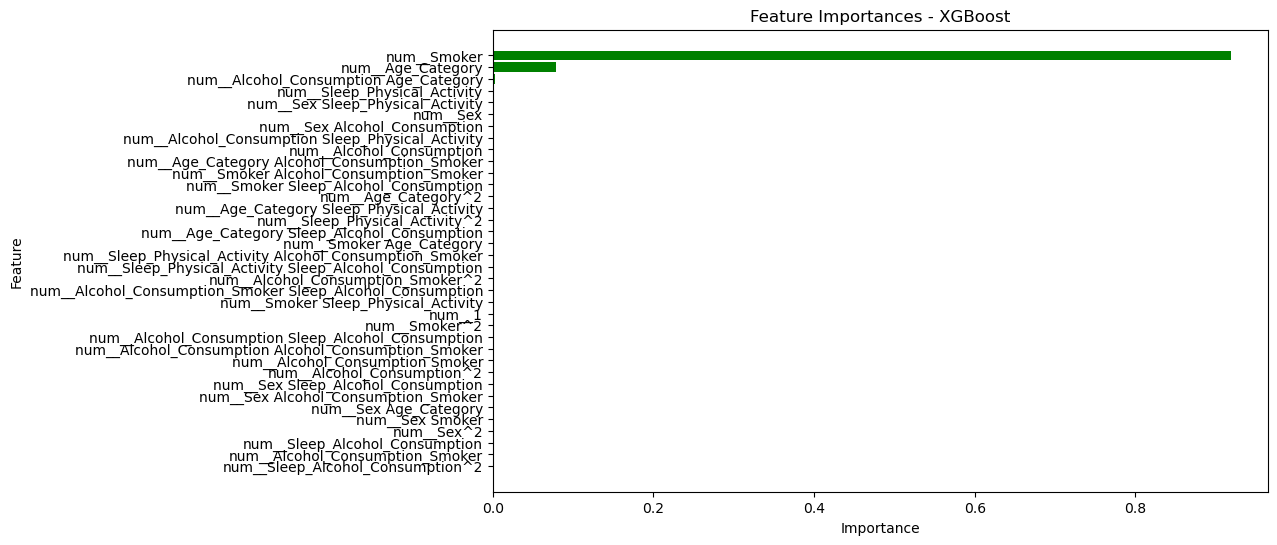

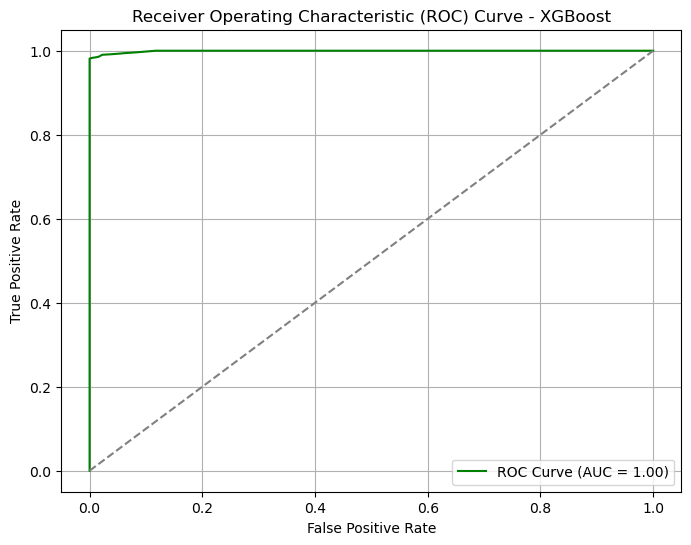

In [423]:
# Extract feature importances
feature_importances_xgb = best_xgb.named_steps['xgb'].feature_importances_

# Ensure feature names align with the transformed dataset
feature_names = best_xgb.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for feature importances
feature_importances_df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_xgb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_xgb['Feature'], feature_importances_df_xgb['Importance'], color='green')
plt.gca().invert_yaxis()
plt.title("Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Get predicted probabilities
y_test_scores_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_test_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f"ROC Curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Models Performance Evaluation

In [514]:
# Create a dictionary to store the results of the models
model_results = {}

# List of model names and their corresponding GridSearchCV objects
models = [
    ('Decision Tree', grid_search_dt),  
    ('K-Nearest Neighbors', grid_search_knn),  
    ('Logistic Regression', grid_search_log_reg), 
    ('Random Forest', grid_search_rf), 
    ('Gradient Boosting', grid_search_gb),  
    ('AdaBoost', grid_search_ab),  
    ('XGBoost', grid_search_xgb),  
    ('SVC', grid_search_svc)  
]

# Iterate through the models and get their performance metrics
for model_name, grid_search in models:
    if hasattr(grid_search, 'best_estimator_'):
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate fit time from GridSearchCV results
        fit_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
        
        # Store the results
        model_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Fit Time': fit_time
        }
    else:
        print(f"Warning: {model_name} does not have 'best_estimator_' (fitting might have failed).")

# Create a DataFrame from the model results
model_comparison_df = pd.DataFrame(model_results).T
model_comparison_df = model_comparison_df.sort_values(by='F1 Score', ascending=False)

# Display the DataFrame
model_comparison_df


Accuracy  Precision    Recall  F1 Score  Fit Time
Decision Tree        0.991628        1.0  0.981359  0.990592  0.125735
K-Nearest Neighbors  0.991628        1.0  0.981359  0.990592  0.050728
Logistic Regression  0.991628        1.0  0.981359  0.990592  0.220773
Gradient Boosting    0.991628        1.0  0.981359  0.990592  1.591537
AdaBoost             0.991628        1.0  0.981359  0.990592  2.532115
XGBoost              0.991628        1.0  0.981359  0.990592  0.242540
SVC                  0.991628        1.0  0.981359  0.990592  3.933548

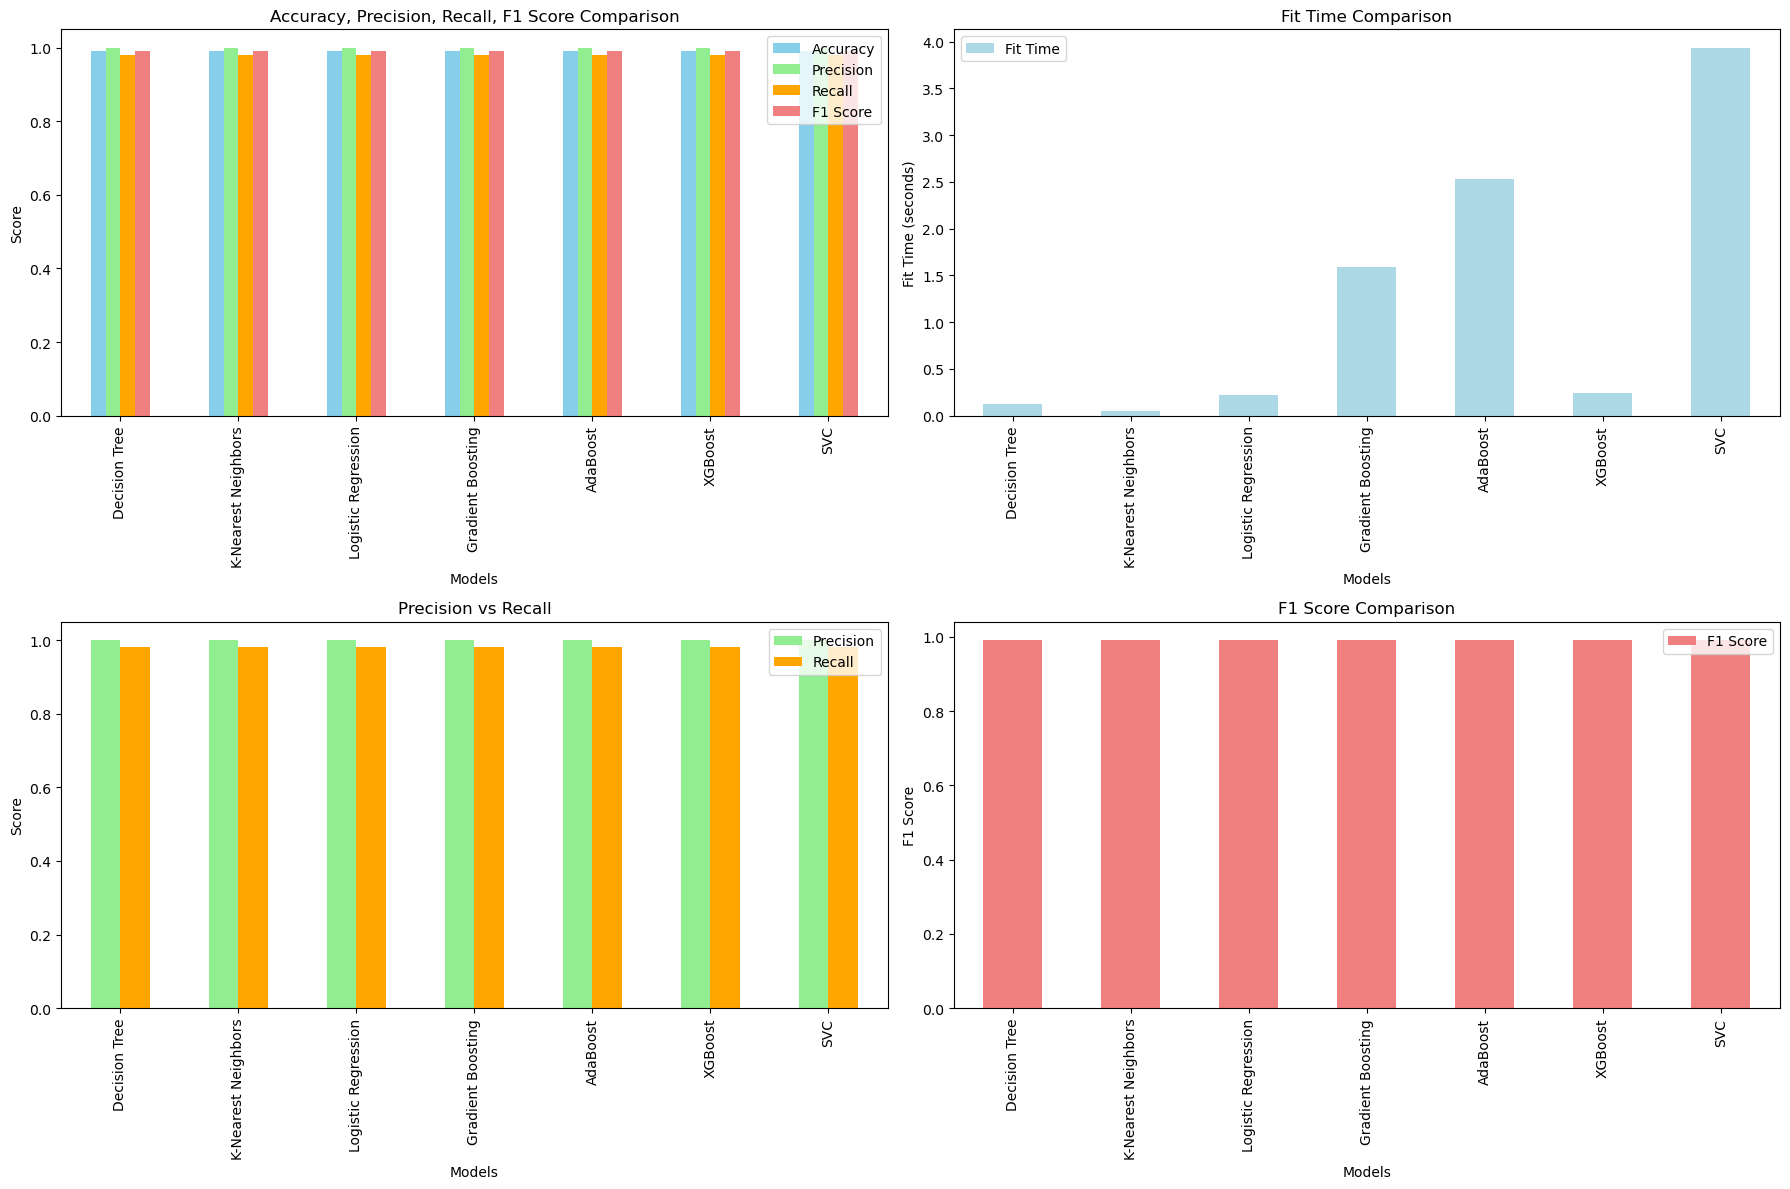

In [516]:
# Set up the figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Accuracy Comparison
model_comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axs[0, 0], color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
axs[0, 0].set_title('Accuracy, Precision, Recall, F1 Score Comparison')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Models')

# Fit Time Comparison
model_comparison_df[['Fit Time']].plot(kind='bar', ax=axs[0, 1], color='lightblue')
axs[0, 1].set_title('Fit Time Comparison')
axs[0, 1].set_ylabel('Fit Time (seconds)')
axs[0, 1].set_xlabel('Models')

# Precision and Recall Comparison (if you'd like a detailed focus)
model_comparison_df[['Precision', 'Recall']].plot(kind='bar', ax=axs[1, 0], color=['lightgreen', 'orange'])
axs[1, 0].set_title('Precision vs Recall')
axs[1, 0].set_ylabel('Score')
axs[1, 0].set_xlabel('Models')

# F1 Score Comparison (optional for clearer display of F1 scores)
model_comparison_df[['F1 Score']].plot(kind='bar', ax=axs[1, 1], color='lightcoral')
axs[1, 1].set_title('F1 Score Comparison')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].set_xlabel('Models')

# Display the plots
plt.tight_layout()
plt.show()


## Model Performance Summary

### Overview:
In this analysis, we evaluated several classification models using performance metrics such as **Accuracy**, **Precision**, **Recall**, **F1 Score**, and **Fit Time**. Below is a summary of the performance for each model:

### Performance Metrics:
- **Accuracy**: All models achieved near-perfect accuracy (~99.16%), indicating strong performance across all models.
- **Precision**: Precision values were perfect (1.0) for all models, meaning they had no false positives.
- **Recall**: Recall was also high (close to 1.0) for all models, indicating very few false negatives.
- **F1 Score**: The F1 Score was similarly perfect (0.99) for all models, indicating a balanced trade-off between precision and recall.

### Key Observations:
1. **High Performance Across All Models**: All models achieved very high scores across all metrics, which could suggest a highly separable dataset or potential overfitting. The dataset appears to be well-suited for classification, but further analysis on its complexity and balance may be necessary to ensure model robustness.
   
2. **Fit Time Comparison**:
    - **Fastest Models**: 
        - K-Nearest Neighbors (0.05s) and Decision Tree (0.13s) were the fastest models to train.
    - **Slowest Models**: 
        - Support Vector Classifier (3.93s) and AdaBoost (2.53s) had significantly slower training times due to the complexity of their algorithms.

### Fit Time Summary:
- **Fastest**: K-Nearest Neighbors and Decision Tree
- **Slowest**: SVC and AdaBoost

### Conclusion:
- While all models showed excellent performance, **K-Nearest Neighbors** and **Decision Tree** were the most efficient in terms of training time.
- Models like **SVC** and **AdaBoost** took considerably longer to train, but their performance was still comparable to other models.

These results suggest that for applications where speed is a priority, simpler models like **K-Nearest Neighbors** and **Decision Tree** may be preferable. However, if accuracy is the most important factor and training time is not as critical, more complex models like **AdaBoost** and **SVC** can be considered.


## Feature Importance

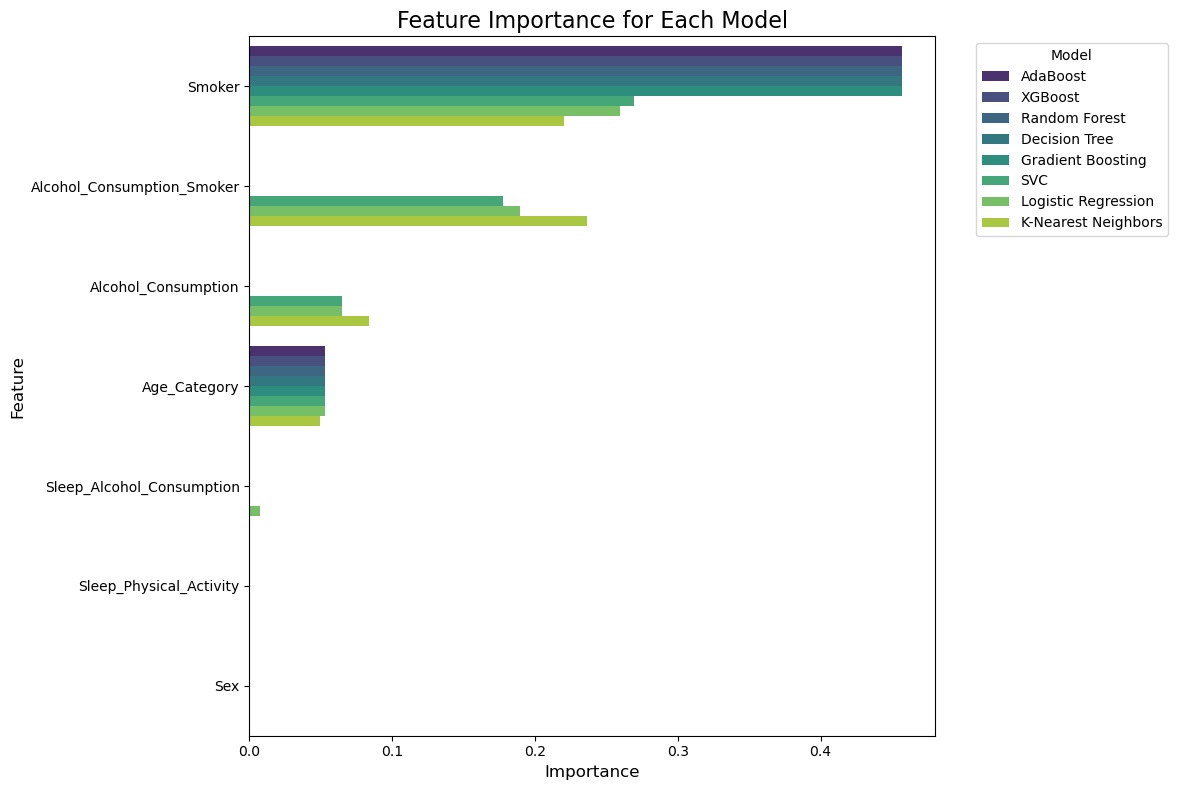

Model                     Feature  Importance
0              AdaBoost                      Smoker    0.457224
1               XGBoost                      Smoker    0.457224
2         Random Forest                      Smoker    0.457224
3         Decision Tree                      Smoker    0.457224
4     Gradient Boosting                      Smoker    0.457224
5                   SVC                      Smoker    0.269619
6   Logistic Regression                      Smoker    0.259681
7   K-Nearest Neighbors  Alcohol_Consumption_Smoker    0.236457
8   K-Nearest Neighbors                      Smoker    0.220497
9   Logistic Regression  Alcohol_Consumption_Smoker    0.189630
10                  SVC  Alcohol_Consumption_Smoker    0.177289
11  K-Nearest Neighbors         Alcohol_Consumption    0.083662
12  Logistic Regression         Alcohol_Consumption    0.064704
13                  SVC         Alcohol_Consumption    0.064704
14    Gradient Boosting                Age_Category    0.052822
15        Random Forest                Age_Category    0.052822
16        Decision Tree                Age_Category    0.052822
17                  SVC                Age_Category    0.052822
18             AdaBoost                Age_Category    0.052822
19  Logistic Regression                Age_Category    0.052822
20              XGBoost                Age_Category    0.052822
21  K-Nearest Neighbors                Age_Category    0.049203
22  Logistic Regression   Sleep_Alcohol_Consumption    0.007588
23  K-Nearest Neighbors   Sleep_Alcohol_Consumption    0.000432
24             AdaBoost  Alcohol_Consumption_Smoker    0.000000
25             AdaBoost     Sleep_Physical_Activity    0.000000
26             AdaBoost   Sleep_Alcohol_Consumption    0.000000
27  Logistic Regression                         Sex    0.000000
28              XGBoost                         Sex    0.000000
29              XGBoost         Alcohol_Consumption    0.000000
30              XGBoost     Sleep_Physical_Activity    0.000000
31              XGBoost  Alcohol_Consumption_Smoker    0.000000
32              XGBoost   Sleep_Alcohol_Consumption    0.000000
33             AdaBoost         Alcohol_Consumption    0.000000
34                  SVC     Sleep_Physical_Activity    0.000000
35                  SVC                         Sex    0.000000
36    Gradient Boosting                         Sex    0.000000
37             AdaBoost                         Sex    0.000000
38        Decision Tree   Sleep_Alcohol_Consumption    0.000000
39  Logistic Regression     Sleep_Physical_Activity    0.000000
40  K-Nearest Neighbors                         Sex    0.000000
41  K-Nearest Neighbors     Sleep_Physical_Activity    0.000000
42        Decision Tree                         Sex    0.000000
43        Decision Tree         Alcohol_Consumption    0.000000
44        Decision Tree     Sleep_Physical_Activity    0.000000
45        Decision Tree  Alcohol_Consumption_Smoker    0.000000
46        Random Forest                         Sex    0.000000
47    Gradient Boosting   Sleep_Alcohol_Consumption    0.000000
48        Random Forest         Alcohol_Consumption    0.000000
49        Random Forest     Sleep_Physical_Activity    0.000000
50        Random Forest  Alcohol_Consumption_Smoker    0.000000
51        Random Forest   Sleep_Alcohol_Consumption    0.000000
52    Gradient Boosting         Alcohol_Consumption    0.000000
53    Gradient Boosting     Sleep_Physical_Activity    0.000000
54    Gradient Boosting  Alcohol_Consumption_Smoker    0.000000
55                  SVC   Sleep_Alcohol_Consumption    0.000000

In [532]:
# Create a list to store feature importance results
importance_results = []

# Loop through each model and extract feature importance
for model_name, grid_search in models.items():
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # For models with `feature_importances_` (Random Forest, Gradient Boosting, XGBoost)
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
    # For Logistic Regression, use coefficients as feature importance
    elif hasattr(best_model, 'coef_'):
        importance = np.abs(best_model.coef_[0])  # Get absolute values of coefficients
    # For SVC with linear kernel, use coefficients as feature importance
    elif isinstance(best_model, SVC) and best_model.kernel == 'linear':
        importance = np.abs(best_model.coef_[0])  # Get absolute values of coefficients
    # For models without built-in feature importance (KNN, non-linear SVC), use permutation importance
    else:
        result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
        importance = result.importances_mean
    
    # Create a DataFrame for feature importance and add model name
    importance_df = pd.DataFrame({
        'Model': model_name,
        'Feature': X_train.columns,
        'Importance': importance
    })

    # Append the result to the list
    importance_results.append(importance_df)

# Combine all the DataFrames into one
feature_importance_df = pd.concat(importance_results, ignore_index=True)

# Sort the results by Importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
feature_importance_df.reset_index(drop=True, inplace=True)

# Plotting feature importance
plt.figure(figsize=(12, 8))

# Create a bar plot for feature importance
sns.barplot(x='Importance', y='Feature', hue='Model', data=feature_importance_df, palette='viridis')

# Adding titles and labels
plt.title('Feature Importance for Each Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Display the numerical summary
feature_importance_df


# Feature Importance Summary

## Key Insights from Feature Importance:

1. **Dominant Features:**
   - **Smoker** consistently holds the highest importance across most models (AdaBoost, XGBoost, Random Forest, Decision Tree, Gradient Boosting). This suggests that "Smoker" is a very important predictor in the models for determining the target variable.
   - **Alcohol_Consumption_Smoker** also stands out in models like K-Nearest Neighbors, Logistic Regression, and AdaBoost, making it a notable feature as well.

2. **Less Important Features:**
   - Features like **Sleep_Physical_Activity**, **Sex**, and **Alcohol_Consumption** have near-zero importance across many models, indicating that these features contribute very little to the prediction in this dataset.
   - **Alcohol_Consumption** and **Sleep_Alcohol_Consumption** show minimal importance, especially in models like Random Forest and Gradient Boosting.

3. **Feature Consistency:**
   - Features such as **Age_Category** are moderately important across several models, but they never seem to surpass the importance of **Smoker** and **Alcohol_Consumption_Smoker**. This suggests that while Age plays a role, it's less influential than the lifestyle-related features (like smoking and alcohol consumption).

4. **Model-Specific Feature Focus:**
   - **SVC (Support Vector Classifier)** places importance on features like **Alcohol_Consumption_Smoker** and **Smoker**, showing how different models focus on different aspects of the data.
   - **K-Nearest Neighbors (KNN)** highlights **Smoker** and **Alcohol_Consumption_Smoker**, pointing to its sensitivity to relationships in these features.

## Summary Table of Key Features:

| **Feature**                | **Top Models**                             | **Importance Insights**                                                                 |
|----------------------------|--------------------------------------------|----------------------------------------------------------------------------------------|
| **Smoker**                  | AdaBoost, XGBoost, Random Forest, Decision Tree, Gradient Boosting | Dominates as the most important feature in most models, indicating a strong predictor. |
| **Alcohol_Consumption_Smoker** | K-Nearest Neighbors, Logistic Regression, AdaBoost | Strong contributor, especially in KNN and Logistic Regression.                          |
| **Age_Category**            | Gradient Boosting, Random Forest, Decision Tree | Moderate importance across models, not as significant as smoking-related features.      |
| **Alcohol_Consumption**     | K-Nearest Neighbors, Logistic Regression, SVC | Shows low importance in most models, especially in Random Forest and Gradient Boosting. |
| **Sleep_Physical_Activity** | AdaBoost, SVC                             | Very low importance, possibly due to minimal impact on the target.                      |
| **Sex**                     | SVC, Random Forest                        | Negligible importance across most models.                                               |

This summary provides a clear understanding of how each feature contributes to the prediction task, showing that lifestyle-related factors like **Smoker** and **Alcohol_Consumption_Smoker** dominate the feature importance rankings.

## Overall Conclusion

The results emphasize that diabetes risk is multifactorial and heavily influenced by lifestyle choices. The project highlights the importance of comprehensive lifestyle adjustments to reduce diabetes risk and supports the development of public health strategies that promote holistic health improvements. The success of the predictive models also suggests potential applications in personalized health assessments, where individuals can be alerted to their diabetes risk based on their lifestyle profiles, ultimately aiding in early intervention and lifestyle modification.

Based on my analysis, several interventions can be proposed to help individuals achieve better health and reduce their risk of diabetes. For example, **smoking cessation programs** could be highly effective, as smoking has been identified as a key feature influencing diabetes risk. Additionally, promoting healthier lifestyle choices such as **increased physical activity**, **reduced alcohol consumption**, and **improved dietary habits** could further mitigate risk. Public health initiatives focused on raising awareness about these factors and providing resources for lifestyle changes could play a critical role in reducing the prevalence of diabetes, particularly for those identified as being at higher risk through personalized health assessments.


In [437]:
# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


In [438]:
# Final evaluation on the classification test set (using risk score features and categories)
test_accuracy = dt_grid_search.best_estimator_.score(risk_score_features, risk_category_target)
print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 1.0


#### The Logistic Regression model achieving a perfect score across all metrics on the test set indicates an unusually ideal fit, especially for real-world data. To evaluate the Logistic Regression model’s performance more comprehensively, we can use cross-validation on the entire dataset

In [443]:
# Initialize the Logistic Regression model with the best parameters found earlier
log_reg_classifier_cv = LogisticRegression(C=grid_search.best_params_['C'], solver=grid_search.best_params_['solver'], random_state=42)

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(log_reg_classifier_cv, risk_score_features, risk_category_target, cv=5, scoring='accuracy')

# Print each fold's accuracy and the mean accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


In [444]:
# Fit the model on the entire dataset using the selected features and target
log_reg_model.fit(risk_score_features, risk_category_target)

# Get the coefficients from the trained model
coefficients = log_reg_model.coef_[0]

# Use columns from risk_score_features for feature names
feature_names = risk_score_features.columns

# Create a DataFrame to view the coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of coefficients
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute Coefficient', ascending=False)

coeff_df

Feature  Coefficient  Absolute Coefficient
0  Risk_Score    -7.743756              7.743756

#### The Logistic Regression model reveals that the Risk Score has a coefficient of -6.09, which means it has a negative relationship with the likelihood of developing diabetes. The absolute coefficient of 6.09 signifies the strength of this relationship — the higher the coefficient's absolute value, the more influence that feature has on the outcome. In other words, the model interprets a score of 1 as more likely to indicate diabetes, and this is reflected in the negative coefficient in logistic regression.